# Predicting Protein Clusters

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# Import Datasets
df_seq = pd.read_csv('/content/pdb_data_seq.csv')
df_char = pd.read_csv('/content/pdb_data_no_dups.csv')

print('Datasets have been loaded...')

Datasets have been loaded...


In [ ]:
protein_char = df_char[df_char.macromoleculeType == 'Protein']
protein_seq = df_seq[df_seq.macromoleculeType == 'Protein']

In [ ]:
protein_char = protein_char[['structureId','classification']]
protein_seq = protein_seq[['structureId','sequence']]
protein_seq.head()

,structureId,sequence
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [ ]:
protein_char.head()

,structureId,classification
2,101M,OXYGEN TRANSPORT
4,102L,HYDROLASE(O-GLYCOSYL)
5,102M,OXYGEN TRANSPORT
7,103L,HYDROLASE(O-GLYCOSYL)
8,103M,OXYGEN TRANSPORT


In [ ]:
model_f = protein_char.set_index('structureId').join(protein_seq.set_index('structureId'))
model_f.head()

,classification,sequence
structureId,,
101M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
102M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
103L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
103M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [ ]:
model_f.shape

(22872, 2)

In [ ]:
model_f.isnull().sum()

classification        0
sequence          11156
dtype: int64

In [ ]:
model_f[model_f.isnull().any(axis=1)]

,classification,sequence
structureId,,
1CC0,SIGNALING PROTEIN,NaN
1FGC,HYDROLASE/HYDROLASE INHIBITOR,NaN
1FGD,BLOOD COAGULATION INHIBITOR,NaN
1FGE,BLOOD COAGULATION INHIBITOR,NaN
1FGG,TRANSFERASE,NaN
...,...,...
1PT9,OXIDOREDUCTASE,NaN
1PTA,HYDROLASE (ORGANOPHOSPHATE-DEGRADING),NaN
1PTD,HYDROLASE (PHOSPHORIC DIESTER),NaN


In [ ]:
model_f = model_f.dropna()

In [ ]:
# model_f = model_f.dropna()
model_f.shape

(11716, 2)

classification
HYDROLASE                                 1198
OXIDOREDUCTASE                            1124
TRANSFERASE                                800
HYDROLASE/HYDROLASE INHIBITOR              486
LYASE                                      409
                                          ... 
MRNA PROCESSING                              1
COMPLEX (PHOSPHOTRANSFERASE/ADENOSINE)       1
ACTIN-BINDING                                1
TRANSFORMING PROTEIN                         1
ANTAGONIST                                   1
Name: count, Length: 861, dtype: int64


<ipython-input-16-e6d8a7b5f1d9>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(counts, hist = False, color = 'purple')


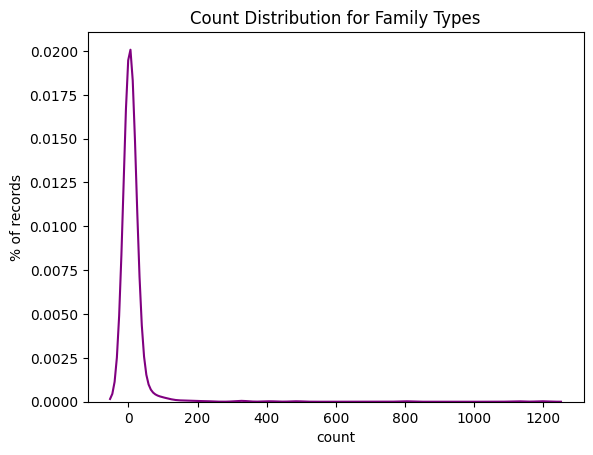

In [ ]:
counts = model_f.classification.value_counts()
print(counts)

plt.figure()
sns.distplot(counts, hist = False, color = 'purple')
plt.title('Count Distribution for Family Types')
plt.ylabel('% of records')
plt.show()

In [ ]:
types = np.asarray(counts[(counts > 1000)].index)

# Filter dataset's records for classification types > 1000
data = model_f[model_f.classification.isin(types)]

print(types)
print('%d is the number of records in the final filtered dataset' %data.shape[0])

['HYDROLASE' 'OXIDOREDUCTASE']
2322 is the number of records in the final filtered dataset


In [ ]:
X_train, X_test,y_train,y_test = train_test_split(data['sequence'], data['classification'], test_size = 0.2, random_state = 1)

# Create a Count Vectorizer to gather the unique elements in sequence
vect = CountVectorizer(analyzer = 'char_wb', ngram_range = (4,4))

# Fit and Transform CountVectorizer
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

#Print a few of the features
print(vect.get_feature_names_out()[-20:])

['yyvn' 'yyvp' 'yyvq' 'yyvs' 'yyvv' 'yywa' 'yywg' 'yywq' 'yywt' 'yywv'
 'yywy' 'yyyd' 'yyye' 'yyym' 'yyyn' 'yyyp' 'yyyq' 'yyys' 'yyyt' 'yyyv']


In [ ]:
prediction = {}

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_df, y_train)
NB_pred = model.predict(X_test_df)
prediction["MultinomialNB"] = accuracy_score(NB_pred, y_test)
print( prediction['MultinomialNB'])

0.978494623655914


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(X_train_df,y_train)
ADA_pred = model.predict(X_test_df)
prediction["Adaboost"] = accuracy_score(ADA_pred , y_test)
print(prediction["Adaboost"])

0.9247311827956989


<Axes: >

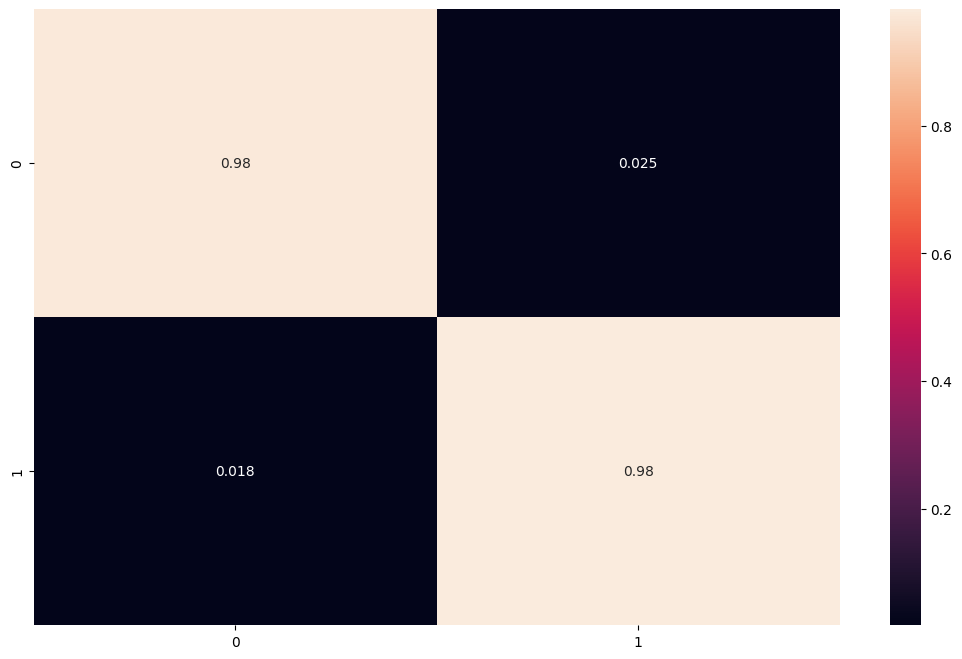

In [ ]:
conf_mat = confusion_matrix(y_test, NB_pred, labels = types)

conf_mat = conf_mat.astype('float')/ conf_mat.sum(axis=1)[:, np.newaxis]

fig , ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.heatmap(conf_mat, annot=True)

In [ ]:
print(types[1])
print(types[0])

OXIDOREDUCTASE
HYDROLASE


In [ ]:
print(classification_report(y_test, NB_pred, target_names = types))

                precision    recall  f1-score   support

     HYDROLASE       0.98      0.98      0.98       243
OXIDOREDUCTASE       0.97      0.98      0.98       222

      accuracy                           0.98       465
     macro avg       0.98      0.98      0.98       465
  weighted avg       0.98      0.98      0.98       465



In [ ]:
print(classification_report(y_test, ADA_pred, target_names = types))

                precision    recall  f1-score   support

     HYDROLASE       0.89      0.98      0.93       243
OXIDOREDUCTASE       0.97      0.87      0.92       222

      accuracy                           0.92       465
     macro avg       0.93      0.92      0.92       465
  weighted avg       0.93      0.92      0.92       465



# Network Analysis

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
G_fb = nx.read_edgelist("facebook_combined.txt", create_using = nx.Graph(), nodetype=int)

In [ ]:
os = nx.spring_layout(G_fb)
betCent = nx.betweenness_centrality(G_fb, normalized=True, endpoints=True)
node_color = [20000.0 * G_fb.degree(v) for v in G_fb]
node_size =  [v * 10000 for v in betCent.values()]

(-0.9498157069087029,
 0.9510040447115898,
 -0.9382952806353568,
 1.1841819044947623)

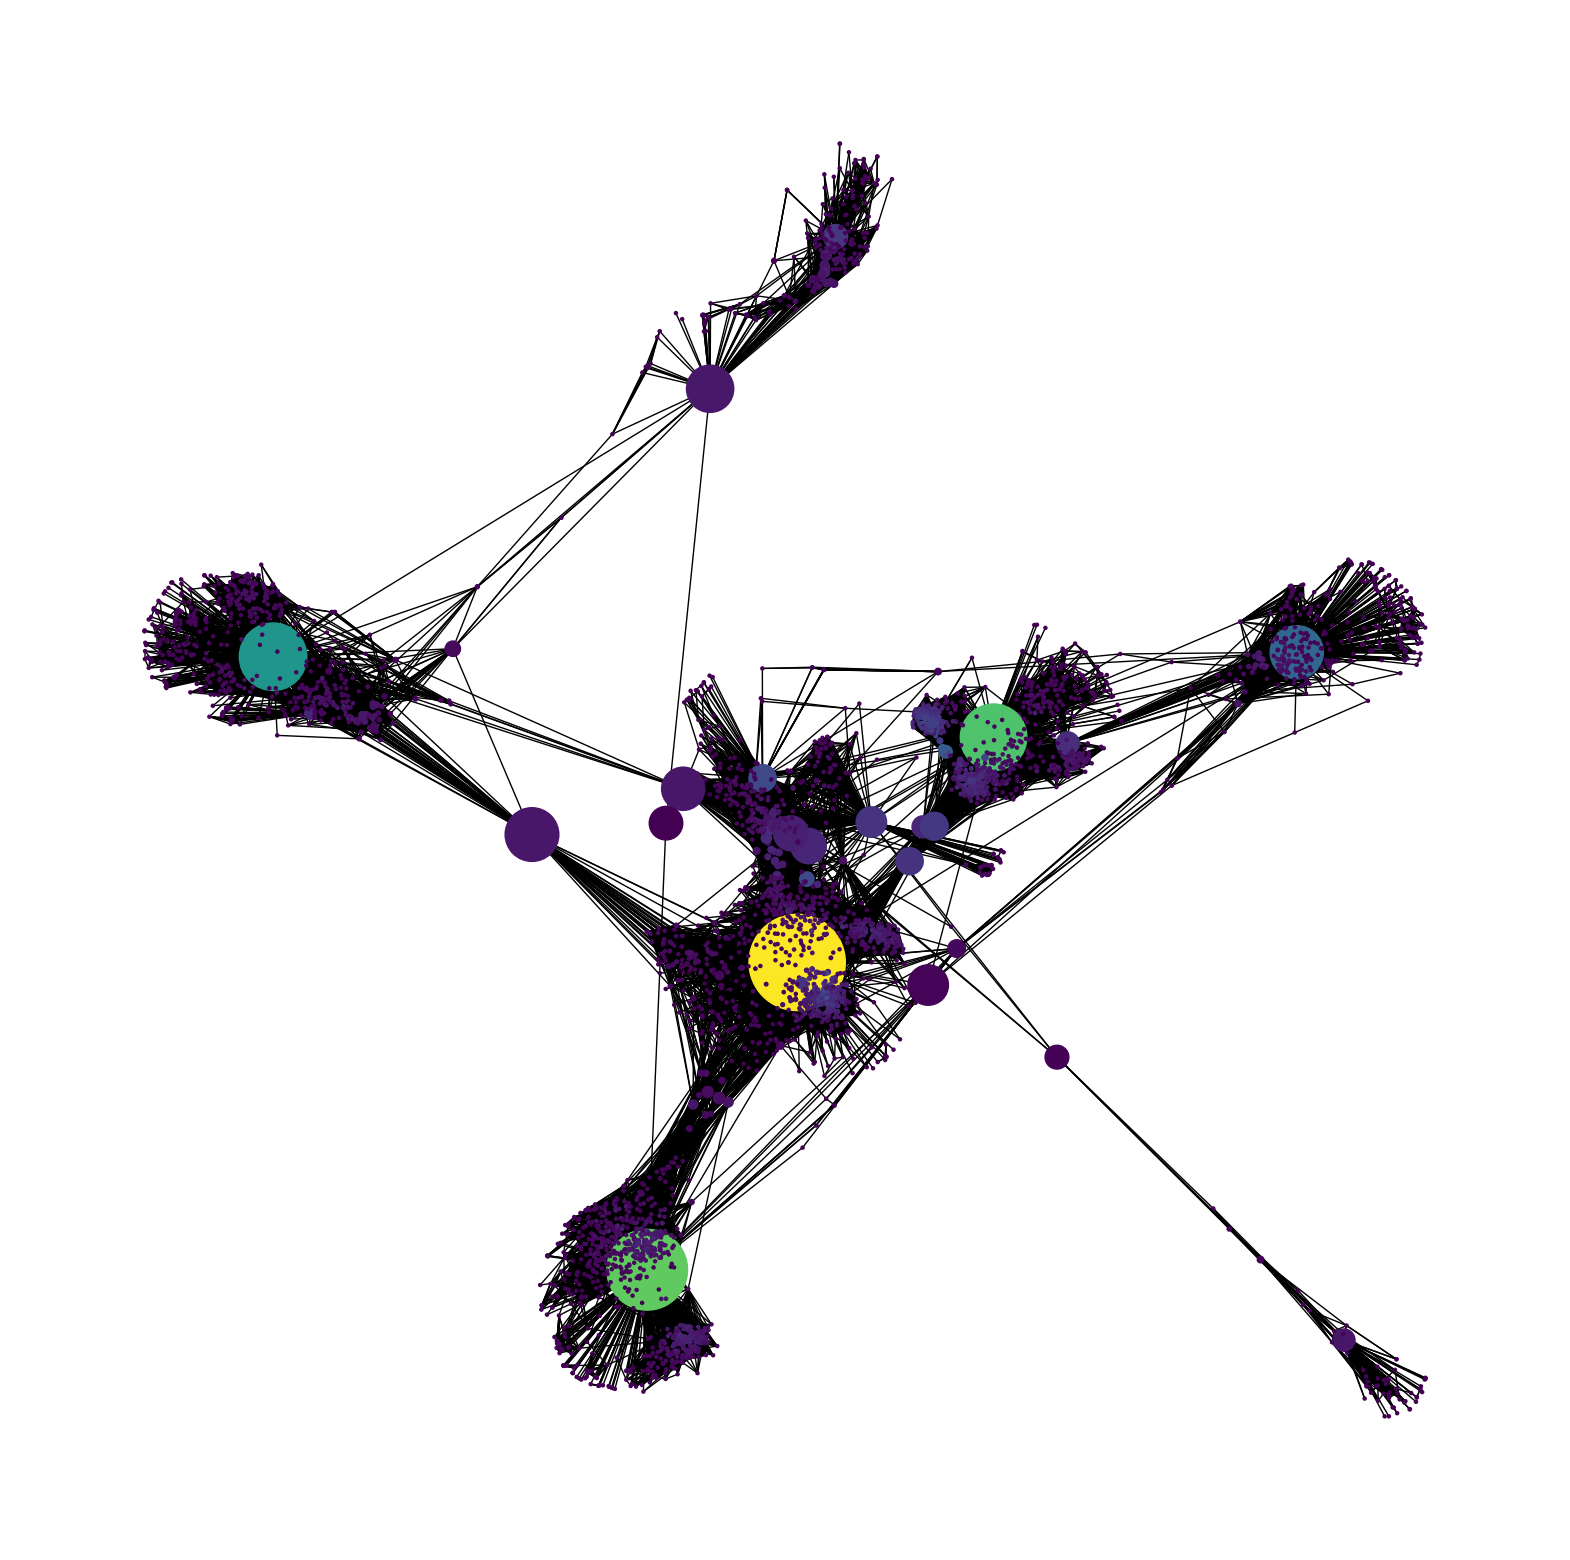

In [ ]:
plt.figure(figsize=(20,20))
nx.draw_networkx(G_fb, pos=os, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

In [ ]:
sorted(betCent, key=betCent.get, reverse=True)[:5]

[107, 1684, 3437, 1912, 1085]

# Bus Map

In [ ]:
!pip install -q pypsa cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.1/354.1 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.2 MB/s eta 0:00:00


In [ ]:
import pypsa
import re
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

In [ ]:
n = pypsa.examples.scigrid_de()
n.calculate_dependent_values()

In [ ]:
n

PyPSA Network 'scigrid-de'
Components:
 - Bus: 585
 - Generator: 1423
 - Line: 852
 - Load: 489
 - StorageUnit: 38
 - Transformer: 96
Snapshots: 24

In [ ]:
n.buses.index

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '382_220kV', '384_220kV', '385_220kV', '391_220kV', '403_220kV',
       '404_220kV', '413_220kV', '421_220kV', '450_220kV', '458_220kV'],
      dtype='object', name='Bus', length=585)

In [ ]:
groups = n.buses.operator.apply(lambda x: re.split(" |,|;", x)[0])
busmap = groups.where(groups != "", n.buses.index)

In [ ]:
n.components["Line"]["attrs"].index[1:]

Index(['bus0', 'bus1', 'type', 'x', 'r', 'g', 'b', 's_nom', 's_nom_mod',
       's_nom_extendable', 's_nom_min', 's_nom_max', 's_max_pu',
       'capital_cost', 'build_year', 'lifetime', 'length', 'carrier',
       'terrain_factor', 'num_parallel', 'v_ang_min', 'v_ang_max',
       'sub_network', 'p0', 'q0', 'p1', 'q1', 'x_pu', 'r_pu', 'g_pu', 'b_pu',
       'x_pu_eff', 'r_pu_eff', 's_nom_opt', 'mu_lower', 'mu_upper'],
      dtype='object', name='attribute')

In [ ]:
n.lines = n.lines.reindex(columns=n.components["Line"]["attrs"].index[1:])
n.lines["type"] = np.nan
n.buses = n.buses.reindex(columns=n.components["Bus"]["attrs"].index[1:])
n.buses["frequency"] = 50

In [ ]:
n.components["Bus"]["attrs"].index[1:]

Index(['v_nom', 'type', 'x', 'y', 'carrier', 'unit', 'v_mag_pu_set',
       'v_mag_pu_min', 'v_mag_pu_max', 'control', 'generator', 'sub_network',
       'p', 'q', 'v_mag_pu', 'v_ang', 'marginal_price'],
      dtype='object', name='attribute')

In [ ]:
C = n.cluster.get_clustering_from_busmap(busmap)

In [ ]:
nc = C.network

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip



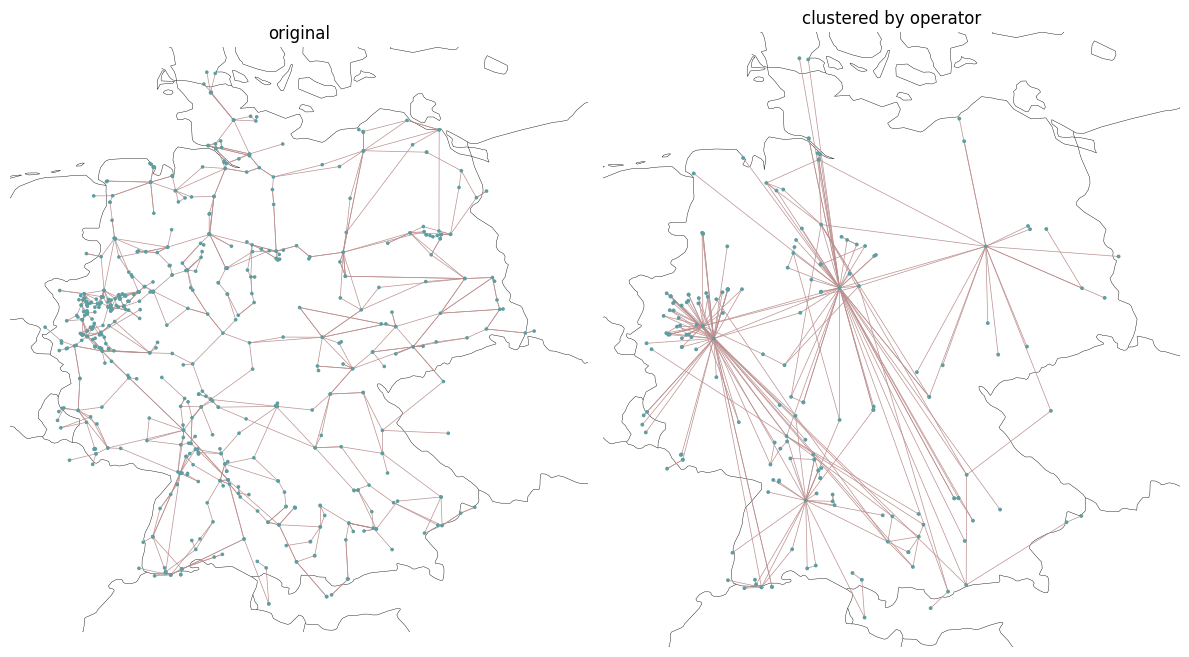

In [ ]:
fig, (ax, ax1) = plt.subplots(
    1, 2, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(12, 12)
)
plot_kwrgs = dict(bus_sizes=1e-3, line_widths=0.5)
n.plot(ax=ax, title="original", **plot_kwrgs)
nc.plot(ax=ax1, title="clustered by operator", **plot_kwrgs)
fig.tight_layout()

In [ ]:
weighting = pd.Series(1, n.buses.index)
busmap2 = n.cluster.busmap_by_kmeans(bus_weightings=weighting, n_clusters=50)

In [ ]:
nc2 = n.cluster.cluster_by_busmap(busmap2)

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



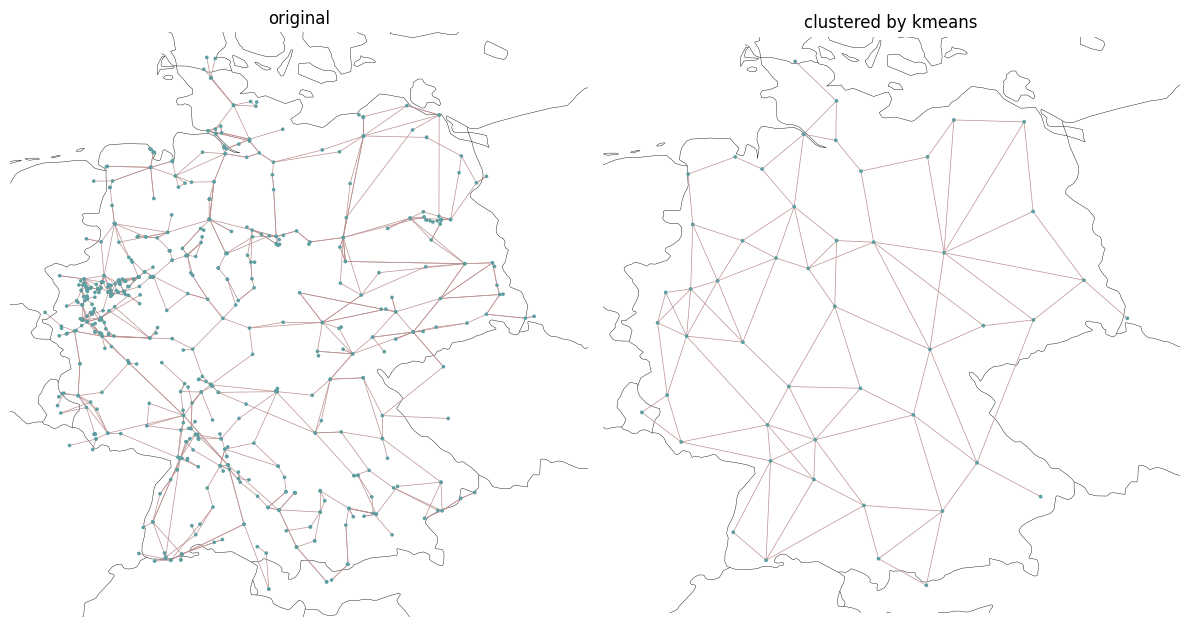

In [ ]:
fig, (ax, ax1) = plt.subplots(
    1, 2, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(12, 12)
)
plot_kwrgs = dict(bus_sizes=1e-3, line_widths=0.5)
n.plot(ax=ax, title="original", **plot_kwrgs)
nc2.plot(ax=ax1, title="clustered by kmeans", **plot_kwrgs)
fig.tight_layout()